# XGBoost - Predict Income using Adult Data Set

In [1]:
import numpy as np
import pandas as pd

## Retrieve Data

In [2]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      skiprows=1, header=None)

#### Check out the data

In [3]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


#### A few issues are already apparent
* There are missing values - marked with '?'
* The target values end with a '.' (in test_set) - but Not in train_set

#### First, add column names

In [5]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
             'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
             'hour_per_week', 'native_country', 'wage_class']

In [6]:
train_set.columns = col_labels
test_set.columns = col_labels

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hour_per_week     32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
len(train_set)

32561

In [9]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hour_per_week     16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


#### There seem to be no null values identified - It is known there are '?' values
* These values will be dropped

In [11]:
print(train_set.replace(' ?', np.nan).dropna().shape)
print(test_set.replace(' ?', np.nan).dropna().shape)

(30162, 15)
(15060, 15)


#### These would be the new shapes - Apply these settings

In [13]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

#### Drop the '.'s in the Target variable
* Change '<=50K.' and '>50K.' - to '<=50K' and '>50K'

In [14]:
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K',
                                                                  ' >50K.': ' >50K'})

#### Check these unique values for each 

In [15]:
test_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [16]:
train_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

## XGBoost requires numerical values
* Encode categorical variable values
* Needs to happen in both datasets
* Ordinal Encoding will be used - One-hot encoding may not be necessary with tree-based models

#### Combine both datasets - to apply encoding to both

In [17]:
combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0)

In [18]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null object
fnlwgt            45222 non-null int64
education         45222 non-null object
education_num     45222 non-null int64
marital_status    45222 non-null object
occupation        45222 non-null object
relationship      45222 non-null object
race              45222 non-null object
sex               45222 non-null object
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hour_per_week     45222 non-null int64
native_country    45222 non-null object
wage_class        45222 non-null object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


#### Use a Loop to apply encoding to make all features numerical

In [20]:
for feature in combined_set.columns:
    if combined_set[feature].dtype == 'object':
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes

In [21]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null int8
fnlwgt            45222 non-null int64
education         45222 non-null int8
education_num     45222 non-null int64
marital_status    45222 non-null int8
occupation        45222 non-null int8
relationship      45222 non-null int8
race              45222 non-null int8
sex               45222 non-null int8
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hour_per_week     45222 non-null int64
native_country    45222 non-null int8
wage_class        45222 non-null int8
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


#### Following encoding, split combined set - back to Training and Test Sets

In [22]:
final_train = combined_set[:train_nomissing.shape[0]]
final_test = combined_set[train_nomissing.shape[0]:]

## XGBoost Model Setup & Grid Search
#### Separate the Target from the other Features

In [23]:
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [24]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Setup first grid search
* binary classification problem

In [25]:
cv_params = {'max_depth': [3,5,7], 'min-child_weight': [1,3,5]}

ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed': 0, 'subsample': 0.8,
             'colsample_bytree': 0.8, 'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                            scoring = 'accuracy', cv = 5, n_jobs = -1)

#### Run Grid Search with 5-fold Cross-Validation - See which Parameters perform best

In [26]:
optimized_GBM.fit(final_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min-child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

#### View Grid Scores

In [27]:
optimized_GBM.grid_scores_

[mean: 0.86725, std: 0.00381, params: {'max_depth': 3, 'min-child_weight': 1},
 mean: 0.86725, std: 0.00381, params: {'max_depth': 3, 'min-child_weight': 3},
 mean: 0.86725, std: 0.00381, params: {'max_depth': 3, 'min-child_weight': 5},
 mean: 0.86224, std: 0.00261, params: {'max_depth': 5, 'min-child_weight': 1},
 mean: 0.86224, std: 0.00261, params: {'max_depth': 5, 'min-child_weight': 3},
 mean: 0.86224, std: 0.00261, params: {'max_depth': 5, 'min-child_weight': 5},
 mean: 0.85522, std: 0.00323, params: {'max_depth': 7, 'min-child_weight': 1},
 mean: 0.85522, std: 0.00323, params: {'max_depth': 7, 'min-child_weight': 3},
 mean: 0.85522, std: 0.00323, params: {'max_depth': 7, 'min-child_weight': 5}]

#### The first few hyperparameter combinations performed best
## Attempt Early Stopping CV 
* to prevent Overfitting

In [28]:
xgdmat = xgb.DMatrix(final_train, y_train)

/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


#### Creating a DMatrix:
* increases xgboost speed 
* it sorts the data initially - optimizing for xgboost when building trees
* especially helpful with a very large training set

#### Specify Parameters - Set Stopping Criteria

In [29]:
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
               metrics = ['error'],
               early_stopping_rounds = 100)

In [30]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
375,0.119239,0.001155,0.130495,0.005232
376,0.119206,0.001135,0.130595,0.005270
377,0.119148,0.001124,0.130495,0.005217
378,0.119090,0.001120,0.130329,0.005051
379,0.119057,0.001072,0.130230,0.005160


#### The CV test error is 13.023 % - 86.977 % accuracy
#### With these settings create and  XGBoost Object - for future reference

In [32]:
our_params = {'eta': 0.1, 'seed': 0, 'subsample': 0.8, 'colsample_bytree': 0.8,
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 379)

#### Plot Feature Importances 

In [33]:
%matplotlib inline
import seaborn as sns

sns.set(font_scale = 1.5)

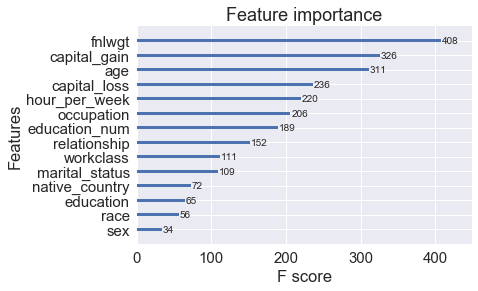

In [35]:
xgb.plot_importance(final_gb)

# xgboost built-in method 

#### 'fnlwgt', 'capital_gain', and 'age' appear to have the greatest importance
#### Another way to view this - using get_fscore

In [36]:
importances = final_gb.get_fscore()
importances

{'relationship': 152,
 'education_num': 189,
 'capital_loss': 236,
 'capital_gain': 326,
 'hour_per_week': 220,
 'age': 311,
 'education': 65,
 'marital_status': 109,
 'fnlwgt': 408,
 'occupation': 206,
 'workclass': 111,
 'sex': 34,
 'race': 56,
 'native_country': 72}

#### With this Dictionary (importances) - Plot importances

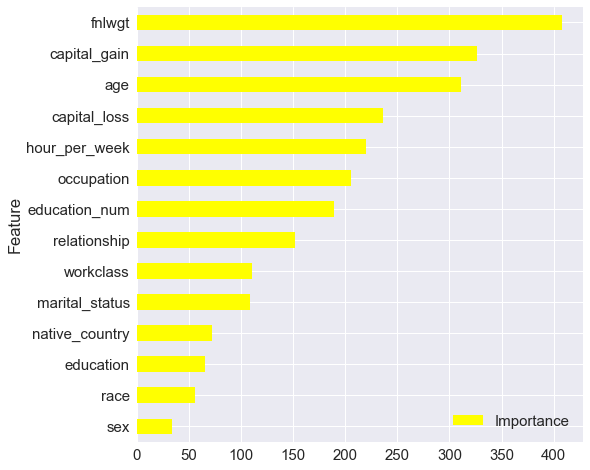

In [37]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize=(8,8), color = 'yellow')

## Analyze Performance on Test Data
* Model has been tuned using CV Grid Search (sklearn API)
* Model has been stopped early (xgboost API)

#### Create another DMatrix for the test data

In [38]:
testdmat = xgb.DMatrix(final_test)

#### Predict

In [39]:
from sklearn.metrics import accuracy_score

y_pred = final_gb.predict(testdmat)
y_pred

array([0.00319613, 0.21690051, 0.28950256, ..., 0.8198074 , 0.17974398,
       0.80232   ], dtype=float32)

#### XGBoost outputs probabilities - Not class labels - Convert these to 0-1 labeling
* set 0.5 as the probability threshold

In [40]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

#### Calculate accuracy

In [41]:
accuracy_score(y_pred, y_test), 1 - accuracy_score(y_pred, y_test)

(0.8702523240371846, 0.12974767596281545)

#### Accuracy of 87.025 %, test error of 12.975 %